# Performance comparison of a UNET-based Image Segmentation of CXR with a CLAHE-based Morphological Segmentation Approach.

### Course: Digital Image Processing 
#### Group: Group 2
Teammates: Akhil Kasturi (akasturi@ur.rochester.edu); Apoorv Sharma (ashar53@ur.rochester.edu) 

In [1]:
import numpy as np 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from IPython.display import clear_output
from keras.optimizers import Adam 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split




Using TensorFlow backend.


# Dataloader and Preprocessing

In [2]:

cxr_path = os.path.join("../input/data/Lung Segmentation/CXR_png")
masks_path = os.path.join("../input/data/Lung Segmentation/","masks/")
cxr_list = os.listdir(cxr_path)
mask_list = os.listdir(masks_path)
masks = [mask.split(".png")[0] for mask in mask_list]
image_file_name = [mask.split("_mask")[0] for mask in masks]
vals = [i for i in masks if "mask" in i]
extras = set(os.listdir(cxr_path)) & set(os.listdir(masks_path))

image_data= []
label_data = []

im_size = 512

for name in vals: 
    image = cv2.imread(os.path.join(cxr_path,name.split("_mask")[0]+".png"))[:,:,0]
    mask = cv2.imread(os.path.join(masks_path,name+".png"))[:,:,0]
    image=cv2.resize(image,(im_size,im_size))
    mask=cv2.resize(mask,(im_size,im_size))
    
    image_data.append(image)
    label_data.append(mask)



In [3]:
image_data2 = np.array(image_data).reshape(len(image_data),im_size,im_size,1)
label_data2 = np.array(label_data).reshape(len(label_data),im_size,im_size,1)     
#Scaling all the CXR image values to range btw 0 to 2
image_data2 = (image_data2-127)/127 #half of 255
label_data2 = label_data2 > 127 #converting them to binary images

print(image_data2.shape)
print(label_data2.shape)


Xtrain, Xtest, ytrain, ytest = train_test_split(image_data2, (label_data2).astype(np.float32), test_size = 0.1,random_state = 1050)

Xtrain, Xval, ytrain, yval = train_test_split(Xtrain,ytrain, test_size = 0.1, random_state = 1050)

#The below is Unscaled data split to test the clahe model.
_, Xtest2, _, ytest2 = train_test_split(np.array(image_data).reshape(len(image_data),im_size,im_size), np.array(label_data).reshape(len(label_data),im_size,im_size) , test_size = 0.1,random_state = 1050)


(566, 512, 512, 1)
(566, 512, 512, 1)


In [4]:
print("Number of images in each split --\n")
print("Training --", Xtrain.shape[0] )
print("Validation --", Xval.shape[0] )
print("Testing --", Xtest.shape[0] )

Number of images in each split --

Training -- 458
Validation -- 51
Testing -- 57


# Displaying the Train and Test Data after Pre-processing

Text(0.5,1,'test data 3')

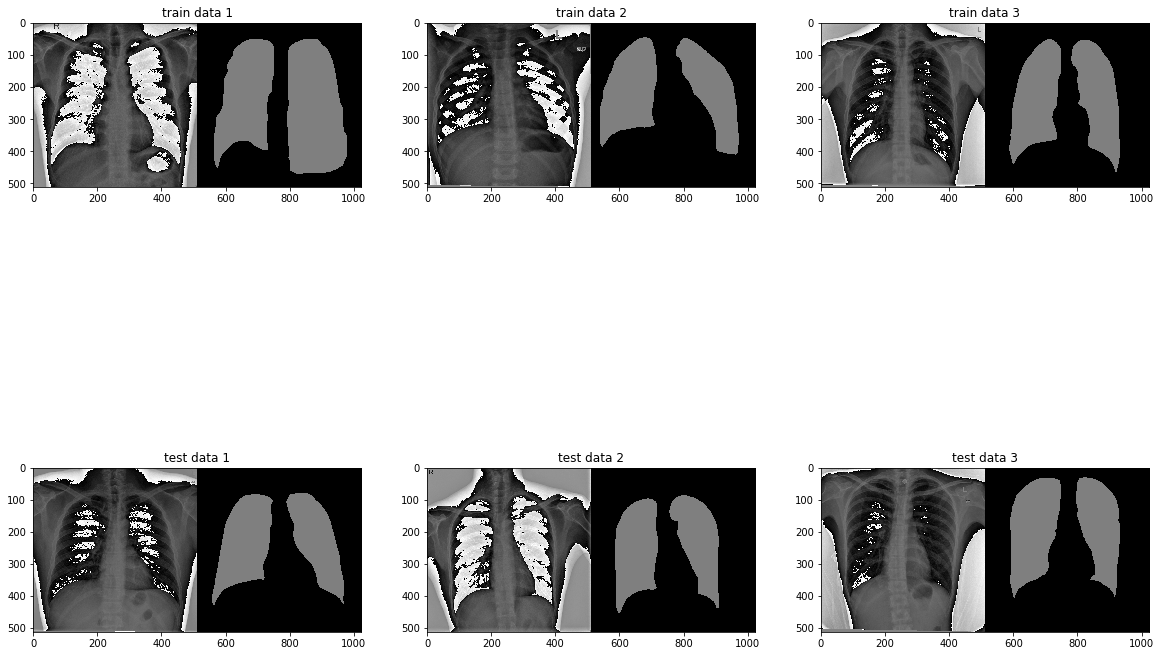

In [5]:
plt.figure(figsize=(20,15))
plt.subplot(2,3,1);plt.imshow(np.hstack((Xtrain[1,:,:,0],ytrain[1,:,:,0])),cmap="gray");plt.title("train data 1")
plt.subplot(2,3,2);plt.imshow(np.hstack((Xtrain[26,:,:,0],ytrain[26,:,:,0])),cmap="gray");plt.title("train data 2")
plt.subplot(2,3,3);plt.imshow(np.hstack((Xtrain[39,:,:,0],ytrain[39,:,:,0])),cmap="gray");plt.title("train data 3")
plt.subplot(2,3,4);plt.imshow(np.hstack((Xtest[13,:,:,0],ytest[13,:,:,0])),cmap="gray");plt.title("test data 1")
plt.subplot(2,3,5);plt.imshow(np.hstack((Xtest[26,:,:,0],ytest[26,:,:,0])),cmap="gray");plt.title("test data 2")
plt.subplot(2,3,6);plt.imshow(np.hstack((Xtest[39,:,:,0],ytest[39,:,:,0])),cmap="gray");plt.title("test data 3")

## Model Implementation 

In [6]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

#### Compile and train the Unet Model

In [7]:
def DiceCoeff(targets, inputs):
    #flattening the labels and the predictions 
    ip = K.flatten(inputs)
    gt = K.flatten(targets)
    
    intersection = K.sum(ip * gt)
    dice = (2*intersection + 1e-6) / (K.sum(gt) + K.sum(ip) + 1e-6)
    return dice

def DiceBCELoss(targets, inputs):    
    #flattening the labels and the predictions 
    ip = K.flatten(inputs)
    gt = K.flatten(targets)
    BCE =  K.binary_crossentropy(gt, ip)
    intersection = K.sum(gt *ip)    
    dice_loss = 1 - (2*intersection + 1e-6) / (K.sum(gt) + K.sum(ip) + 1e-6)
    Dice_BCE = BCE + dice_loss
    return Dice_BCE

def DiceLoss_np(targets, inputs):
    #Numpy version of Dice loss for test data evaluation
    ip = np.ravel(inputs)
    gt = np.ravel(targets)
    
    intersection = np.sum(gt* ip)
    dice = (2*intersection + 1e-6) / (np.sum(gt) + np.sum(ip) + 1e-6)
    return 1 - dice

### Model

In [8]:
model = unet()
model.compile(optimizer=Adam(lr=1e-5), loss=DiceBCELoss,metrics=[DiceCoeff, 'binary_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Training the model

In [9]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
#weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint("BestCheckpoint.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", mode="min",patience=10) 
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10,verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001)


model.compile(optimizer=Adam(lr=1e-5), loss=[DiceBCELoss],metrics = [DiceCoeff, 'binary_accuracy'])

loss_history = model.fit(x = Xtrain,y = ytrain, batch_size = 1,epochs = 100, validation_data =(Xval,yval) , callbacks=[checkpoint,reducelr, early])




Train on 458 samples, validate on 51 samples
Epoch 1/100
458/458 [==============================] - 17s 37ms/step - loss: 1.3022 - DiceCoeff: 0.3673 - binary_accuracy: 0.7183 - val_loss: 1.1424 - val_DiceCoeff: 0.4877 - val_binary_accuracy: 0.8323

Epoch 00001: val_loss improved from inf to 1.14243, saving model to BestCheckpoint.hdf5
Epoch 2/100
458/458 [==============================] - 12s 26ms/step - loss: 0.8270 - DiceCoeff: 0.5889 - binary_accuracy: 0.8802 - val_loss: 0.6419 - val_DiceCoeff: 0.6772 - val_binary_accuracy: 0.8860

Epoch 00002: val_loss improved from 1.14243 to 0.64191, saving model to BestCheckpoint.hdf5
Epoch 3/100
458/458 [==============================] - 12s 26ms/step - loss: 0.5783 - DiceCoeff: 0.7027 - binary_accuracy: 0.8934 - val_loss: 0.5820 - val_DiceCoeff: 0.7076 - val_binary_accuracy: 0.8957

Epoch 00003: val_loss improved from 0.64191 to 0.58196, saving model to BestCheckpoint.hdf5
Epoch 4/100
458/458 [==============================] - 12s 26ms/step - 

## Plot the metric and evaluate 

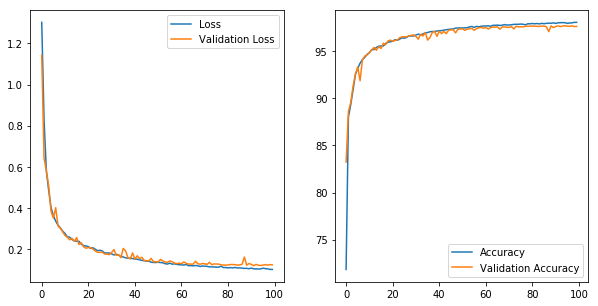

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()
ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-', label = 'Validation Accuracy')
ax2.legend()

## Test the model

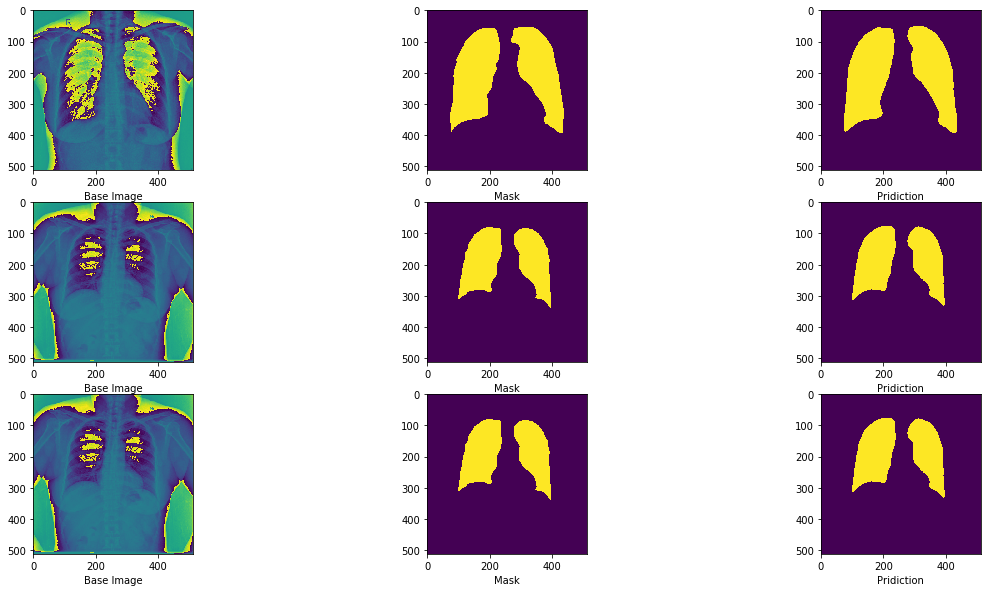

In [11]:
pred_indexes = np.random.randint(1,Xtest.shape[0],10)
#predicting the test values from the model
ypreds = model.predict(Xtest)
ypreds = ypreds> 0.5
plt.figure(figsize=(20,10))

for i in range(0,9,3):
    #Plotting Test Image
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(Xtest[pred_indexes[i]]))
    plt.xlabel("Base Image")
    
    #Ground Truth Mask
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(ytest[pred_indexes[i]]))
    plt.xlabel("Mask")
    
    #Predicted Mask
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(ypreds[pred_indexes[i]]))
    plt.xlabel("Pridiction")


In [12]:
from sklearn.metrics import accuracy_score
import skimage.filters as filters
preds = model.predict(Xtest)
tpreds2 = preds> 0.5
loss = DiceLoss_np(tpreds2,ytest )
print('Model Loss on Test Data: {0:.3f}'.format(loss))
print("Model Accuracy on Test Data: {0:.4f}".format(accuracy_score(tpreds2.flatten(),ytest.flatten())))

Model Loss on Test Data: 0.047
Model Accuracy on Test Data: 0.9756


# 2. Chest XRay Segmentation using CLAHE based morphological approach.

In [13]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import numpy as np

def Tmask(image):
    """masks the thorasic region"""
    #measures the sum of pixels along axis 0 and drawing a rectangluar mask at that point in the same axis the sum is considered
    pixel_sum =np.sum(image,0)
    max_pt =np.int_(len(pixel_sum)/3)+np.argmax(pixel_sum[np.int_(len(pixel_sum)/3):np.int_(len(pixel_sum)*2/3)])
    cv2.line(image,(max_pt,0),(max_pt,512),0,25)
    return image

def DoContours(image, thresh):
    #detecting the contour points
    contour_points, _ =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    temp = np.zeros(len(contour_points))
    #contours using Green's formulae
    for j in range(len(contour_points)):
        cp = contour_points[j]
        temp[j] = cv2.contourArea(cp)
    retVal = np.zeros(image.shape)
    #fills areas bounded by contours
    cv2.drawContours(retVal, contour_points, np.argmax(temp), (255), -1)
    return retVal

def feature_mask(image):
    #finding features in an image for the purpose of tracking.
    findCorners = np.int0(cv2.goodFeaturesToTrack(image, 3800, 0.001, 1))
    #initiating np zeros
    cmask = np.zeros(image.shape)
    for cr in findCorners:
        x,y = cr.ravel()
        cv2.circle(cmask,(x,y),6,1,-1)
    return cmask


def SegmentCXR(image):
    """This function segments Chest XRays and returns segmented binary masks"""
    image = cv2.resize(image, (512,512), interpolation = cv2.INTER_AREA)
    #Masking thorasic region
    tmask_ = Tmask(image)
    #applying cv2 CLAHE model
    apply_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = apply_clahe.apply(tmask_)
    
    #applying BlackHat
    ker = 190
    kernel = np.ones((ker,ker),np.uint8)
    blackhat = cv2.morphologyEx(cl1, cv2.MORPH_BLACKHAT, kernel) 
    
    #Obtaining Feature corners
    fmask = feature_mask(cl1)
    
    #Applying binary threshold
    _, thresh = cv2.threshold(blackhat, 45, 255, 0)
    mask = np.multiply(fmask,thresh).astype('uint8')
    median = cv2.medianBlur(mask,25) 
    
    #Applying Contours 
    contours_ = DoContours(median, thresh).astype('uint8')   
    #Multiplying the contours with mask to fill holes and get a better segmented version of cxr 
    mul_mask = np.multiply((contours_/contours_.max()), median)
    mul_mask = (mul_mask/ mul_mask.max())*255
    
    #morphological operations
    square = np.ones((10, 10), np.uint8) 
    m2 = cv2.erode(mul_mask, square, iterations=3) #3 iterations of erosion
    dil = cv2.dilate(m2, square, iterations=6) #6 iterations of dilation
    
    #Averaging the image and finally taking a binary threshold of the image 
    avg2 = (dil + mul_mask)/2 
    avg = (avg2 > 250)*255
    #avg = IP.medfil2d(avg, 2)
    
    #Applying an opening opertion on the averaged binary image
    eli = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    res = cv2.morphologyEx(avg.astype('uint8'),cv2.MORPH_OPEN,eli)
    return res #, cl1, blackhat, contour_mask, mask_out, avg2

In [21]:
#Splitting the data from UNSCALED LIST, as the clahe model is tuned to deal with images of between pixel values [0,255]


clahe_pred = np.array([SegmentCXR(img) for img in Xtest2])

cpred2 = clahe_pred> 0.5
ytest2 = ytest>0.5

loss = DiceLoss_np(cpred2,ytest2 )
print('Model2 Loss on Test Data: {0:.3f}'.format(loss))
print("Model2 Accuracy on Test Data: {0:.4f}".format(accuracy_score(cpred2.flatten(),ytest2.flatten())))

Model2 Loss on Test Data: 0.179
Model2 Accuracy on Test Data: 0.9001


In [28]:
Xtest2_unscaled = np.array(Xtest2).reshape(Xtest2.shape[0],im_size,im_size,1)
ytest2_unscaled = np.array(ytest2).reshape(ytest2.shape[0],im_size,im_size,1)  

#predicting the test values from the model
ypreds = model.predict((Xtest2_unscaled - 127)/127)
ypreds = ypreds> 0.5

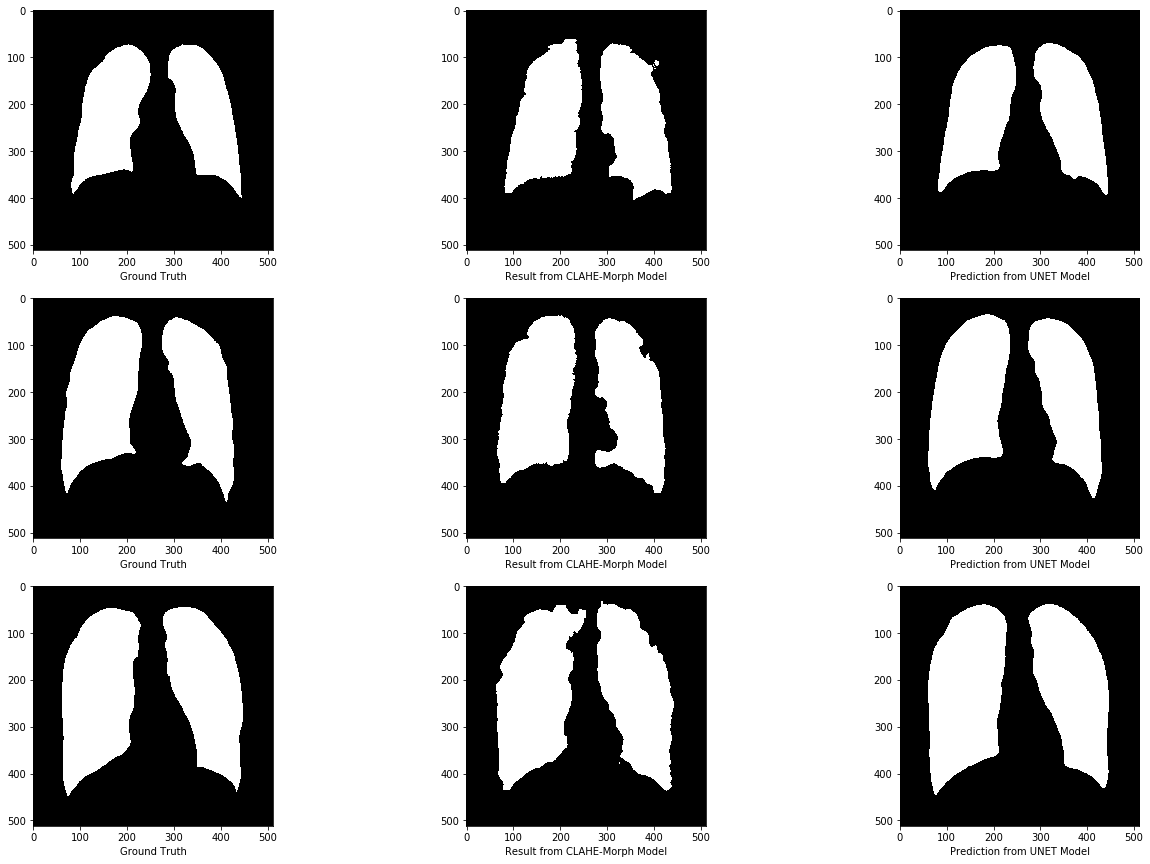

In [38]:
pred_indexes = np.random.randint(1,Xtest2_unscaled.shape[0],10)


plt.figure(figsize=(22,15))

for i in range(0,9,3):
    #Plotting Test Image
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(ytest2_[pred_indexes[i]]),cmap="gray")
    plt.xlabel("Ground Truth")
    
    #Ground Truth Mask
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(clahe_pred[pred_indexes[i]]),cmap="gray")
    plt.xlabel("Result from CLAHE-Morph Model")
    
    #Predicted Mask
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(ypreds[pred_indexes[i]]),cmap="gray")
    plt.xlabel("Prediction from UNET Model")